---
title: "OOD Detection: Distance-Based and Contrastive Learning"
teaching: 0
exercises: 0
---

## Questions
- How do distance-based methods like Mahalanobis distance and KNN work for OOD detection?
- What is contrastive learning and how does it improve feature representations?
- How does contrastive learning enhance the effectiveness of distance-based OOD detection methods?

## Objectives
- Gain a thorough understanding of distance-based OOD detection methods, including Mahalanobis distance and KNN.
- Learn the principles of contrastive learning and its role in improving feature representations.
- Explore the synergy between contrastive learning and distance-based OOD detection methods to enhance detection performance.

# Example 3: Distance-Based Methods
*Lee et al., A simple unified framework for detecting out-of-distribution samples and adversarial attacks. NeurIPS 2018.*

With softmax and energy-based methods, we focus on the models outputs to determine a threshold that defines ID and OOD data. With distance-based methods, we focus on the feature representations learned by the model.

In the case of neural networks, a common approach is to use the penultimate layer as a feature representation that can define an ID clusters for each class. You can then use distance to the closesent centroid as a proxy for OOD measure.

## Mahalanobis distance (parametric)
Model the feature space as a mixture of multivariate Gaussian distribution, one for each class. use distance to the closest centroid as proxy for OOD measure

### Limiations of parametric approach
* Strong distributional assumption (features may not necessarily be Gassian-distributed)
* Suboptimal embedding

## Nearest Neighbor Distance (non-parametric)
*Sun et al., Out-of-distribution Detection with Deep Nearest Neighbors, ICML 2022*

* Sample considered OOD if it has a large KNN distrance w.r.t. training data (and vice versa)
* No distributional assumptions about underlying embedding space. Stronger generality and flexibility than mahalanobis distancew

## CIDER
This one might be out of scope...

Ming et al., How to Exploit Hyperspherical Embeddings for Out-of-Distribution Detection

# Contrastive Learning

* Explain the basic idea of contrastive learning: learning representations by contrasting positive and negative pairs.
* Highlight the role of contrastive learning in learning discriminative features that can separate in-distribution (ID) from OOD data more effectively.
* Illustrate how contrastive learning improves the feature space, making distance-based methods (like Mahalanobis and KNN) more effective.
* Provide examples or case studies where contrastive learning has been applied to enhance OOD detection.

# Example X: Comparing feature representations with and without contrastive learning


## Returning to UMAP
Notice how in our UMAP visualization, we say three distinct clusters representing each class. However, our model still confidently rated many sandals as being tshirts. The crux of this issue is that models do not know what they don't know. They simply draw classifcation boundaries between the classes available to them during training.

One way to get around this problem is to train models to learn discriminative features...

## Contrastive learning
In this experiment, we use both a traditional neural network and a contrastive learning model to classify images from the Fashion MNIST dataset, focusing on T-shirts (class 0) and Trousers (class 1). Additionally, we evaluate the models on out-of-distribution (OOD) data, specifically Sandals (class 5). To visualize the models' learned features, we extract features from specific layers of the neural networks and reduce their dimensionality using UMAP.

## Overview of steps

#### 1) Train model

* With or without contrastive learning
* Focusing on T-shirts (class 0) and Trousers (class 1)
* Additionally, we evaluate the models on out-of-distribution (OOD) data, specifically Sandals (class 5)

#### 2) Feature Extraction:

* After training, we set the models to evaluation mode to prevent updates to the model parameters.
* For each subset of the data (training, validation, and OOD), we pass the images through the entire network up to the first fully connected layer.
* The output of this layer, which captures high-level features and abstractions, is then used as a 1D feature vector.
* These feature vectors are detached from the computational graph and converted to NumPy arrays for further processing.

#### 3) Dimensionality Reduction and Visualization:

* We combine the feature vectors from the training, validation, and OOD data into a single dataset.
* UMAP (Uniform Manifold Approximation and Projection) is used to reduce the dimensionality of the feature vectors from the high-dimensional space to 2D, making it possible to visualize the relationships between different data points.
* The reduced features are then plotted, with different colors representing the training data (T-shirts and Trousers), validation data (T-shirts and Trousers), and OOD data (Sandals).

By visualizing the features generated from different subsets of the data, we can observe how well the models have learned to distinguish between in-distribution classes (T-shirts and Trousers) and handle OOD data (Sandals). This approach allows us to evaluate the robustness and generalization capabilities of the models in dealing with data that may not have been seen during training.

## Standard neural network w/out contrastive learning

### 1) Train model
We'll first train our vanilla CNN w/out contrastive learning.

* Focusing on T-shirts (class 0) and Trousers (class 1)
* Additionally, we evaluate the models on out-of-distribution (OOD) data, specifically Sandals (class 5)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Define a simple CNN model for classification
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes for T-shirts and Trousers

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset and filter for T-shirts and Trousers
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_indices = np.where((train_dataset.targets == 0) | (train_dataset.targets == 1))[0]
val_indices = np.where((test_dataset.targets == 0) | (test_dataset.targets == 1))[0]
ood_indices = np.where(test_dataset.targets == 5)[0]

# Use a subset of the data for quicker training
train_subset = Subset(train_dataset, np.random.choice(train_indices, size=5000, replace=False))
val_subset = Subset(test_dataset, np.random.choice(val_indices, size=1000, replace=False))
ood_subset = Subset(test_dataset, np.random.choice(ood_indices, size=1000, replace=False))

train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)
ood_loader = DataLoader(ood_subset, batch_size=256, shuffle=False)

# Initialize the model and move it to the device
classification_model = ClassificationModel().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

# Training loop for standard neural network
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    total_train_loss = 0
    classification_model.train()
    for batch_images, batch_labels in train_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = classification_model(batch_images)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    total_val_loss = 0
    classification_model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = classification_model(batch_images)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



Epoch 1, Train Loss: 0.3210, Val Loss: 0.1134
Epoch 2, Train Loss: 0.0668, Val Loss: 0.0705
Epoch 3, Train Loss: 0.0453, Val Loss: 0.0531
Epoch 4, Train Loss: 0.0329, Val Loss: 0.0457
Epoch 5, Train Loss: 0.0273, Val Loss: 0.0395
Epoch 6, Train Loss: 0.0194, Val Loss: 0.0391
Epoch 7, Train Loss: 0.0181, Val Loss: 0.0365
Epoch 8, Train Loss: 0.0129, Val Loss: 0.0310
Epoch 9, Train Loss: 0.0100, Val Loss: 0.0287
Epoch 10, Train Loss: 0.0088, Val Loss: 0.0297


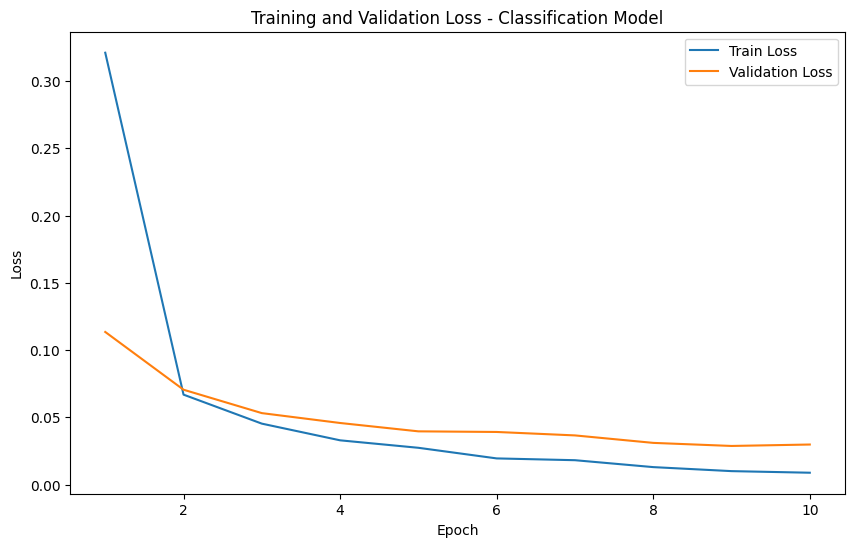

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Classification Model')
plt.legend()
plt.show()

### 2) Extracting learned features

* After training, we set the models to evaluation mode to prevent updates to the model parameters.
* For each subset of the data (training, validation, and OOD), we pass the images through the entire network up to the first fully connected layer.
* The output of this layer, which captures high-level features and abstractions, is then used as a 1D feature vector.
* These feature vectors are detached from the computational graph and converted to NumPy arrays for further processing.

#### Why later layer features are better
In both the traditional neural network and the contrastive learning model, we will extract features from the first fully connected layer (fc1) before the final classification layer. Here's why this layer is particularly suitable for feature extraction:

* **Hierarchical feature representation**: In neural networks, the initial layers typically capture low-level features such as edges, textures, and simple shapes (e.g., with CNNs). As you move deeper into the network, the layers capture higher-level, more abstract features that are more relevant for the final classification task. These high-level features are combinations of the low-level features and are typically more discriminative.

* **Better separation of classes**: Features from later layers have been transformed through several layers of non-linear activations and pooling operations, making them more suitable for distinguishing between classes.
These features are usually more compact and have a better separation in the feature space, which helps in visualization and understanding the model's decision-making process.

In [ ]:
# Extract features using the trained classification model
classification_model.eval()
train_features = []
train_labels_list = []
for batch_images, batch_labels in train_loader:
    batch_images = batch_images.to(device)
    features = classification_model.fc1(classification_model.flatten(classification_model.conv1(batch_images)))
    train_features.append(features.detach().cpu().numpy())
    train_labels_list.append(batch_labels.numpy())

val_features = []
val_labels_list = []
for batch_images, batch_labels in val_loader:
    batch_images = batch_images.to(device)
    features = classification_model.fc1(classification_model.flatten(classification_model.conv1(batch_images)))
    val_features.append(features.detach().cpu().numpy())
    val_labels_list.append(batch_labels.numpy())

ood_features = []
ood_labels_list = []
for batch_images, batch_labels in ood_loader:
    batch_images = batch_images.to(device)
    features = classification_model.fc1(classification_model.flatten(classification_model.conv1(batch_images)))
    ood_features.append(features.detach().cpu().numpy())
    ood_labels_list.append(batch_labels.numpy())


### 3) Dimensionality Reduction and Visualization:

* We combine the feature vectors from the training, validation, and OOD data into a single dataset.
* UMAP (Uniform Manifold Approximation and Projection) is used to reduce the dimensionality of the feature vectors from the high-dimensional space to 2D, making it possible to visualize the relationships between different data points.
* The reduced features are then plotted, with different colors representing the training data (T-shirts and Trousers), validation data (T-shirts and Trousers), and OOD data (Sandals).


In [ ]:
train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels_list)
val_features = np.concatenate(val_features)
val_labels = np.concatenate(val_labels_list)
ood_features = np.concatenate(ood_features)
ood_labels = np.concatenate(ood_labels_list)

# Perform UMAP to visualize the classification model features
combined_features = np.vstack([train_features, val_features, ood_features])
combined_labels = np.hstack([train_labels, val_labels, np.full(len(ood_labels), 2)])  # Use 2 for OOD class

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(combined_features)

# Split the results back into train, val, and OOD data
umap_train_features = umap_results[:len(train_features)]
umap_val_features = umap_results[len(train_features):len(train_features) + len(val_features)]
umap_ood_features = umap_results[len(train_features) + len(val_features):]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


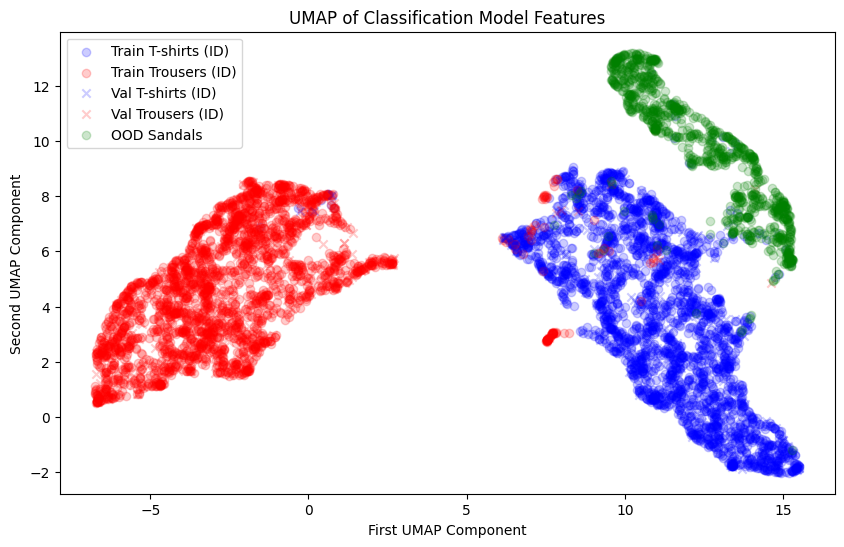

In [ ]:
# Plotting UMAP components for classification model
alpha = .2
plt.figure(figsize=(10, 6))
# Plot train T-shirts
scatter1 = plt.scatter(umap_train_features[train_labels == 0, 0], umap_train_features[train_labels == 0, 1], c='blue', alpha=alpha, label='Train T-shirts (ID)')
# Plot train Trousers
scatter2 = plt.scatter(umap_train_features[train_labels == 1, 0], umap_train_features[train_labels == 1, 1], c='red', alpha=alpha, label='Train Trousers (ID)')
# Plot val T-shirts
scatter3 = plt.scatter(umap_val_features[val_labels == 0, 0], umap_val_features[val_labels == 0, 1], c='blue', alpha=alpha, marker='x', label='Val T-shirts (ID)')
# Plot val Trousers
scatter4 = plt.scatter(umap_val_features[val_labels == 1, 0], umap_val_features[val_labels == 1, 1], c='red', alpha=alpha, marker='x', label='Val Trousers (ID)')
# Plot OOD Sandals
scatter5 = plt.scatter(umap_ood_features[:, 0], umap_ood_features[:, 1], c='green', alpha=alpha, marker='o', label='OOD Sandals')
plt.legend(handles=[scatter1, scatter2, scatter3, scatter4, scatter5])
plt.xlabel('First UMAP Component')
plt.ylabel('Second UMAP Component')
plt.title('UMAP of Classification Model Features')
plt.show()

## Neural network trained with contrastive learning

### What is Contrastive Learning?

Contrastive learning is a technique where the model learns to distinguish between similar and dissimilar pairs of data. This can be achieved through different types of learning: supervised, unsupervised, and self-supervised.

* Supervised Contrastive Learning: Uses labeled data to create pairs or groups of similar and dissimilar data points based on their labels.

* Unsupervised Contrastive Learning: Does not use any labels. Instead, it relies on inherent patterns in the data to create pairs. For example, random pairs of data points might be assumed to be dissimilar, while augmented versions of the same data point might be assumed to be similar.

* Self-Supervised Contrastive Learning: A form of unsupervised learning where the model generates its own supervisory signal from the data. This typically involves data augmentation techniques where positive pairs are created by augmenting the same image (e.g., cropping, rotating), and negative pairs are formed from different images.

In contrastive learning, the model learns to bring similar pairs closer in the embedding space while pushing dissimilar pairs further apart. This approach is particularly useful for tasks like image retrieval, clustering, and representation learning.

Certainly! Let's expand on how we are treating the T-shirt, Trouser, and Sandals classes in the context of our supervised contrastive learning framework.

### Key Concepts in Our Code

### Data Preparation
   - **Dataset**: We use the Fashion MNIST dataset, which contains images of various clothing items, each labeled with a specific class.
   - **Class Filtering**: For this exercise, we are focusing on three classes from the Fashion MNIST dataset:
     - **T-shirts** (class label 0)
     - **Trousers** (class label 1)
     - **Sandals** (class label 5)
   - **In-Distribution (ID) Data**: We treat T-shirts and Trousers as our primary classes for training. These are considered "in-distribution" data.
   - **Out-of-Distribution (OOD) Data**: Sandals are treated as a different class for testing the robustness of our learned embeddings, making them "out-of-distribution" data.

### Pairs Creation

For each image in our training set:
- **Positive Pair**: We find another image of the same class (either T-shirt or Trouser). These pairs are labeled as similar.
- **Negative Pair**: We randomly choose an image from a different class (T-shirt paired with Trouser or vice versa). These pairs are labeled as dissimilar.

By creating these pairs, the model learns to produce embeddings where similar images (same class) are close together, and dissimilar images (different classes) are farther apart.

### Model Architecture

The model is a simple Convolutional Neural Network (CNN) designed to output embeddings. It consists of:
- Two convolutional layers to extract features from the images.
- Fully connected layers to map these features to a 50-dimensional embedding space.

### Training Process

- **Forward Pass**: The model processes pairs of images and outputs their embeddings.
- **Contrastive Loss**: We use a contrastive loss function to train the model. This loss encourages embeddings of similar pairs to be close and embeddings of dissimilar pairs to be far apart. Specifically, we:
  - Normalize the embeddings.
  - Calculate similarity scores.
  - Compute the contrastive loss, which penalizes similar pairs if they are not close enough and dissimilar pairs if they are too close.

### Differences from Standard Neural Network Training

- **Data Pairing**: In contrastive learning, we create pairs of data points. Standard neural network training typically involves individual data points with corresponding labels.
- **Loss Function**: We use a contrastive loss function instead of the typical cross-entropy loss used in classification tasks. The contrastive loss is designed to optimize the relative distances between pairs of embeddings.
- **Supervised Learning**: Our approach uses labeled data to form similar and dissimilar pairs, making it supervised contrastive learning. This contrasts with self-supervised or unsupervised methods where labels are not used.

### Specific Type of Contrastive Learning

The specific contrastive learning technique we are using here is a form of **supervised contrastive learning**. This involves using labeled data to create similar and dissimilar pairs of images. The model is trained to output embeddings where a contrastive loss function is applied to these pairs. By doing so, the model learns to map images into an embedding space where similar images are close together, and dissimilar images are farther apart.

By training with this method, the model learns robust feature representations that are useful for various downstream tasks, even with limited labeled data. This is powerful because it allows leveraging labeled data to improve the model's performance and generalizability.

### Application of the Framework

1. **Training with In-Distribution Data**:
   - **T-shirts and Trousers**: These classes are used to train the model. Positive and negative pairs are created within this subset to teach the model to distinguish between the two classes.
   
2. **Testing with Out-of-Distribution Data**:
   - **Sandals**: This class is used to test the robustness of the embeddings learned by the model. By introducing a completely different class during testing, we can evaluate how well the model generalizes to new, unseen data.

This framework demonstrates how supervised contrastive learning can be effectively applied to learn discriminative embeddings that can generalize well to both in-distribution and out-of-distribution data.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import umap
import torch.nn as nn
import torch.optim as optim

class PairDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img1 = self.images[idx]
        label1 = self.labels[idx]
        idx2 = np.random.choice(np.where(self.labels == label1)[0])
        img2 = self.images[idx2]
        return img1, img2, label1

# Load Fashion MNIST dataset and filter for T-shirts and Trousers
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_indices = np.where((train_dataset.targets == 0) | (train_dataset.targets == 1))[0]
val_indices = np.where((test_dataset.targets == 0) | (test_dataset.targets == 1))[0]
ood_indices = np.where(test_dataset.targets == 5)[0]

# Use a subset of the data for quicker training
train_subset = Subset(train_dataset, np.random.choice(train_indices, size=5000, replace=False))
val_subset = Subset(test_dataset, np.random.choice(val_indices, size=1000, replace=False))
ood_subset = Subset(test_dataset, np.random.choice(ood_indices, size=1000, replace=False))

# Create DataLoaders for the subsets
train_images = np.array([train_dataset[i][0].numpy() for i in train_indices])
train_labels = np.array([train_dataset[i][1] for i in train_indices])
val_images = np.array([test_dataset[i][0].numpy() for i in val_indices])
val_labels = np.array([test_dataset[i][1] for i in val_indices])
ood_images = np.array([test_dataset[i][0].numpy() for i in ood_indices])
ood_labels = np.array([test_dataset[i][1] for i in ood_indices])

train_loader = DataLoader(PairDataset(train_images, train_labels), batch_size=256, shuffle=True)
val_loader = DataLoader(PairDataset(val_images, val_labels), batch_size=256, shuffle=False)
ood_loader = DataLoader(PairDataset(ood_images, ood_labels), batch_size=256, shuffle=False)

# Inspect the data loaders
for batch_images1, batch_images2, batch_labels in train_loader:
    print(f"train_loader batch_images1 shape: {batch_images1.shape}")
    print(f"train_loader batch_images2 shape: {batch_images2.shape}")
    print(f"train_loader batch_labels shape: {batch_labels.shape}")
    break

for batch_images1, batch_images2, batch_labels in val_loader:
    print(f"val_loader batch_images1 shape: {batch_images1.shape}")
    print(f"val_loader batch_images2 shape: {batch_images2.shape}")
    print(f"val_loader batch_labels shape: {batch_labels.shape}")
    break

for batch_images1, batch_images2, batch_labels in ood_loader:
    print(f"ood_loader batch_images1 shape: {batch_images1.shape}")
    print(f"ood_loader batch_images2 shape: {batch_images2.shape}")
    print(f"ood_loader batch_labels shape: {batch_labels.shape}")
    break


train_loader batch_images1 shape: torch.Size([256, 1, 28, 28])
train_loader batch_images2 shape: torch.Size([256, 1, 28, 28])
train_loader batch_labels shape: torch.Size([256])
val_loader batch_images1 shape: torch.Size([256, 1, 28, 28])
val_loader batch_images2 shape: torch.Size([256, 1, 28, 28])
val_loader batch_labels shape: torch.Size([256])
ood_loader batch_images1 shape: torch.Size([256, 1, 28, 28])
ood_loader batch_images2 shape: torch.Size([256, 1, 28, 28])
ood_loader batch_labels shape: torch.Size([256])


In [ ]:
# Define a simple CNN model for contrastive learning
class ContrastiveModel(nn.Module):
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 50)  # Embedding size

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define contrastive loss function
def contrastive_loss(z_i, z_j, temperature=0.5):
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)

    sim = torch.mm(z, z.t()) / temperature
    sim_i_j = torch.diag(sim, batch_size)
    sim_j_i = torch.diag(sim, -batch_size)

    positives = torch.cat([sim_i_j, sim_j_i], dim=0)
    negatives_mask = ~torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    negatives = sim[negatives_mask].view(2 * batch_size, -1)

    loss = -torch.mean(positives) + torch.mean(negatives)
    return loss

# Training loop for contrastive learning
def train_contrastive_model(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for img1, img2, _ in train_loader:
            img1, img2 = img1.to(device), img2.to(device)

            optimizer.zero_grad()

            z_i = model(img1)
            z_j = model(img2)

            loss = contrastive_loss(z_i, z_j)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Instantiate the model, optimizer, and start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
contrastive_model = ContrastiveModel().to(device)
optimizer = optim.Adam(contrastive_model.parameters(), lr=0.001)

train_contrastive_model(contrastive_model, train_loader, optimizer, num_epochs=n_epochs)


Epoch [1/10], Loss: -1.5171
Epoch [2/10], Loss: -1.8654
Epoch [3/10], Loss: -1.9083
Epoch [4/10], Loss: -1.9292
Epoch [5/10], Loss: -1.9169
Epoch [6/10], Loss: -1.9379
Epoch [7/10], Loss: -1.9325
Epoch [8/10], Loss: -1.9334
Epoch [9/10], Loss: -1.9482
Epoch [10/10], Loss: -1.9718


### 2) Extracting learned features

* After training, we set the models to evaluation mode to prevent updates to the model parameters.
* For each subset of the data (training, validation, and OOD), we pass the images through the entire network up to the first fully connected layer.
* The output of this layer, which captures high-level features and abstractions, is then used as a 1D feature vector.
* These feature vectors are detached from the computational graph and converted to NumPy arrays for further processing.


In [ ]:
# Extract features using the trained contrastive model
contrastive_model.eval()
train_features = []
train_labels_list = []
for img1, _, label1 in train_loader:
    img1 = img1.to(device)
    features = contrastive_model.fc1(contrastive_model.flatten(contrastive_model.conv1(img1)))
    train_features.append(features.detach().cpu().numpy())
    train_labels_list.append(label1.numpy())

val_features = []
val_labels_list = []
for img1, _, label1 in val_loader:
    img1 = img1.to(device)
    features = contrastive_model.fc1(contrastive_model.flatten(contrastive_model.conv1(img1)))
    val_features.append(features.detach().cpu().numpy())
    val_labels_list.append(label1.numpy())

ood_features = []
ood_labels_list = []
for img1, _, label1 in ood_loader:
    img1 = img1.to(device)
    features = contrastive_model.fc1(contrastive_model.flatten(contrastive_model.conv1(img1)))
    ood_features.append(features.detach().cpu().numpy())
    ood_labels_list.append(label1.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels_list)
val_features = np.concatenate(val_features)
val_labels = np.concatenate(val_labels_list)
ood_features = np.concatenate(ood_features)
ood_labels = np.concatenate(ood_labels_list)

# Diagnostic print statements
print(f"train_features shape: {train_features.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"val_features shape: {val_features.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"ood_features shape: {ood_features.shape}")
print(f"ood_labels shape: {ood_labels.shape}")

train_features shape: (12000, 128)
train_labels shape: (12000,)
val_features shape: (2000, 128)
val_labels shape: (2000,)
ood_features shape: (1000, 128)
ood_labels shape: (1000,)


### 3) Dimensionality Reduction and Visualization:

* We combine the feature vectors from the training, validation, and OOD data into a single dataset.
* UMAP (Uniform Manifold Approximation and Projection) is used to reduce the dimensionality of the feature vectors from the high-dimensional space to 2D, making it possible to visualize the relationships between different data points.
* The reduced features are then plotted, with different colors representing the training data (T-shirts and Trousers), validation data (T-shirts and Trousers), and OOD data (Sandals).


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


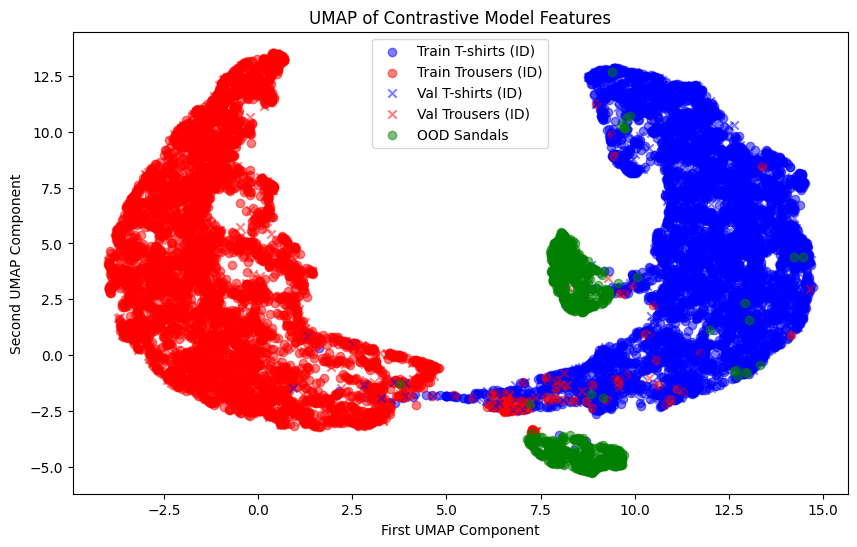

In [ ]:
# Ensure the labels array for OOD matches the feature array length
combined_features = np.vstack([train_features, val_features, ood_features])
combined_labels = np.hstack([train_labels, val_labels, np.full(len(ood_features), 2)])  # Use 2 for OOD class

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(combined_features)

# Split the results back into train, val, and OOD data
umap_train_features = umap_results[:len(train_features)]
umap_val_features = umap_results[len(train_features):len(train_features) + len(val_features)]
umap_ood_features = umap_results[len(train_features) + len(val_features):]

# Plotting UMAP components for contrastive learning model
plt.figure(figsize=(10, 6))
# Plot train T-shirts
scatter1 = plt.scatter(umap_train_features[train_labels == 0, 0], umap_train_features[train_labels == 0, 1], c='blue', alpha=0.5, label='Train T-shirts (ID)')
# Plot train Trousers
scatter2 = plt.scatter(umap_train_features[train_labels == 1, 0], umap_train_features[train_labels == 1, 1], c='red', alpha=0.5, label='Train Trousers (ID)')
# Plot val T-shirts
scatter3 = plt.scatter(umap_val_features[val_labels == 0, 0], umap_val_features[val_labels == 0, 1], c='blue', alpha=0.5, marker='x', label='Val T-shirts (ID)')
# Plot val Trousers
scatter4 = plt.scatter(umap_val_features[val_labels == 1, 0], umap_val_features[val_labels == 1, 1], c='red', alpha=0.5, marker='x', label='Val Trousers (ID)')
# Plot OOD Sandals
scatter5 = plt.scatter(umap_ood_features[:, 0], umap_ood_features[:, 1], c='green', alpha=0.5, marker='o', label='OOD Sandals')
plt.legend(handles=[scatter1, scatter2, scatter3, scatter4, scatter5])
plt.xlabel('First UMAP Component')
plt.ylabel('Second UMAP Component')
plt.title('UMAP of Contrastive Model Features')
plt.show()


# Limitations of Threshold-Based OOD Detection Methods

Threshold-based out-of-distribution (OOD) detection methods are widely used due to their simplicity and intuitive nature. However, they come with several significant limitations that need to be considered:

1. **Dependence on OOD Data Choice**:
   - **Variety and Representation**: The effectiveness of threshold-based methods heavily relies on the variety and representativeness of the OOD data used during threshold selection. If the chosen OOD samples do not adequately cover the possible range of OOD scenarios, the threshold may not generalize well to unseen OOD data.
   - **Threshold Determination**: To determine a robust threshold, it is essential to include a diverse set of OOD samples. This helps in setting a threshold that can effectively distinguish between in-distribution and out-of-distribution data across various scenarios. Without a comprehensive OOD dataset, the threshold might either be too conservative, causing many ID samples to be misclassified as OOD, or too lenient, failing to detect OOD samples accurately.

2. **Impact of High Thresholds**:
   - **False OOD Classification**: High thresholds can lead to a significant number of ID samples being incorrectly classified as OOD. This false OOD classification results in the loss of potentially valuable data, reducing the efficiency and performance of the model.
   - **Data Efficiency**: In applications where retaining as much ID data as possible is crucial, high thresholds can be particularly detrimental. It’s important to strike a balance between detecting OOD samples and retaining ID samples to ensure the model’s overall performance and data efficiency.

3. **Sensitivity to Model Confidence**:
   - **Model Calibration**: Threshold-based methods rely on the model's confidence scores, which can be misleading if the model is poorly calibrated. Overconfident predictions for ID samples or underconfident predictions for OOD samples can result in suboptimal threshold settings.
   - **Confidence Variability**: The variability in confidence scores across different models and architectures can make it challenging to set a universal threshold. Each model might require different threshold settings, complicating the deployment and maintenance of threshold-based OOD detection systems.

4. **Lack of Discriminative Features**:
   - **Boundary-Based Detection**: Threshold-based methods focus on class boundaries rather than learning discriminative features that can effectively separate ID and OOD samples. This approach can be less robust, particularly in complex or high-dimensional data spaces where class boundaries might be less clear.
   - **Feature Learning**: By relying solely on confidence scores, these methods miss the opportunity to learn and leverage features that are inherently more discriminative. This limitation highlights the need for advanced techniques like contrastive learning, which focuses on learning features that distinguish between ID and OOD samples more effectively.

### Conclusion

While threshold-based OOD detection methods offer a straightforward approach, their limitations underscore the importance of considering additional OOD samples for robust threshold determination and the potential pitfalls of high thresholds. Transitioning to methods that learn discriminative features rather than relying solely on class boundaries can address these limitations, paving the way for more effective OOD detection. This sets the stage for discussing contrastive learning, which provides a powerful framework for learning such discriminative features.
